In [132]:
import sys
#sys.path.remove('/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from math import isclose

from copy import deepcopy

import importlib

import time
import pickle
import random

In [133]:
import main

from main import delta_2_eta0
from main import Gamma_2_eta
from main import eta0_2_delta
from main import eta_2_Gamma

np.random.seed(0)
random.seed(0)

# Initialize Parameters

In [134]:
# parameters for data
K = [2,2]
T = 1000
experiment = 1


if experiment == 1:
    
    Gamma = [np.array([[0.9,0.1],
                       [0.1,0.9]]),
             [np.array([[0.75,0.25],
                        [0.25,0.75]]),
              np.array([[0.25,0.75],
                        [0.75,0.25]])]]

    delta = [np.array([0.9,0.1]),
             [np.array([0.9,0.1]),
              np.array([0.1,0.9])]]
    
    
    Gamma_coarse_full = np.kron(Gamma[0],np.ones((2,2)))
    Gamma_fine_full = np.block([[Gamma[1][0],np.tile(delta[1][1],(2,1))],
                                [np.tile(delta[1][0],(2,1)),Gamma[1][1]]])
    
    Gamma_full = Gamma_coarse_full * Gamma_fine_full
    delta_full = np.repeat(delta[0],2) * np.concatenate(delta[1])
    
    mus = {'Y'      : np.array([1,1,2,2]), # coarse-scale mus
           'Y_star' : np.array([1,2,1,2])} # fine-scale mus
    
    sigs = {'Y'      : np.exp(np.array([-2,-2,-2,-2])), # coarse-scale sigs
            'Y_star' : np.exp(np.array([-2,-2,-2,-2]))} # fine-scale sigs
    
elif experiment == 2:
    
    Gamma = np.array([[0.99,0.005,0.005],
                      [0.005,0.99,0.005],
                      [0.005,0.005,0.99]])
    delta = np.ones(K[0])/K[0]
    mus = np.array(range(K[0])).astype("float64")
    sigs = np.exp(np.array([-1.0,1.0,0.0]))

    
# optimization parameters 
methods = ["BFGS","CG","Nelder-Mead","Newton-CG","L-BFGS-B"]
# methods = ["EM","SGD","SAG","SVRG","SAGA","GD","BFGS","Nelder-Mead"]

# pick optimization settings
step_sizes = {"EM"  : [None,None],
              "CG": [None,None],
              "BFGS": [None,None],
              "GD"  : [0.01,0.01],
              "SGD" : [0.01,0.01],
              "SAG" : [0.01,0.01],
              "SVRG": [0.01,0.01],
              "SAGA": [0.01,0.01]}

num_epochs = 100
tol = 1e-8
grad_tol = 1e-8

# Simulate Data

In [135]:
X = np.zeros(T,dtype=int)
data = []

for t in range(T):
    
    if t == 0:
        X[t] = np.random.choice(K[0]*K[1],p=delta_full)
    else:
        X[t] = np.random.choice(K[0]*K[1],p=Gamma_full[X[t-1]])

    data.append({'Y'      : mus['Y'][X[t]] + sigs['Y'][X[t]]*np.random.normal(),
                 'Y_star' : mus['Y_star'][X[t]] + sigs['Y_star'][X[t]]*np.random.normal()})

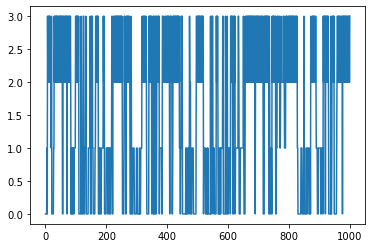

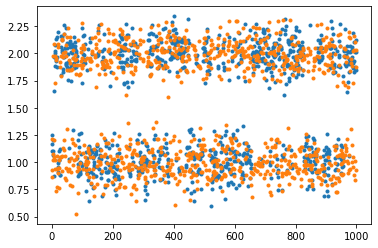

In [136]:
plt.plot(X)
plt.show()
plt.plot([x["Y"] for x in data],'.')
plt.plot([x["Y_star"] for x in data],'.')
plt.show()

# save data
np.savetxt('../dat/data.csv', 
           np.array([x['Y'] for x in data]), 
           delimiter=',')

# Load in Whale Data

In [156]:
df = pd.read_csv("../dat/Final_Data.csv")

data = []

for row in df[["diveDuration","maxDepth","avg_bot_htv"]].iterrows():
    data.append({"diveDuration" : row[1]["diveDuration"],
                 "maxDepth"     : row[1]["maxDepth"],
                 "avg_bot_htv"  : row[1]["avg_bot_htv"]})

# Train the HMM

In [157]:
# initialize optims
optims = {}
times = {}

In [158]:
importlib.reload(main)
for method in methods:
    print(method)
    optims[method] = main.optimizor(data,K)
    
    optims[method].theta = [{'Y': {'mu': np.array([1.0,2.0]),
                                   'log_sig': np.array([-2.0,-2.0]),
                                   'corr': np.array([0.0,0.0])}},
                            [{'Y_star': {'mu': np.array([1.0,2.0]),
                                         'log_sig': np.array([-2.0,-2.0]),
                                         'corr': np.array([0.0,0.0])}},
                             {'Y_star': {'mu': np.array([1.0,2.0]),
                                         'log_sig': np.array([-2.0,-2.0]),
                                         'corr': np.array([0.0,0.0])}}]]

    optims[method].Gamma = [np.array([[0.9,0.1],
                                      [0.1,0.9]]),
                            [np.array([[0.75,0.25],
                                       [0.25,0.75]]),
                             np.array([[0.25,0.75],
                                       [0.75,0.25]])]]

    optims[method].delta = [np.array([0.9,0.1]),
                            [np.array([0.9,0.1]),
                             np.array([0.1,0.9])]]

    optims[method].eta0 = delta_2_eta0(optims[method].delta)
    optims[method].eta = Gamma_2_eta(optims[method].Gamma)
    
    optims[method].train_HHMM(num_epochs=num_epochs,
                              method=method)#,
                              #tol=tol)

BFGS


KeyError: 'Y'

In [116]:
optims

{'BFGS': <main.optimizor at 0x7fc3ee6fe390>,
 'CG': <main.optimizor at 0x7fc3ed670e10>,
 'Nelder-Mead': <main.optimizor at 0x7fc3ed6a0850>}

In [119]:
optims["CG"].theta

[{'Y': {'mu': array([1.04416704, 1.98807537]),
   'log_sig': array([-2.07371077, -2.08670865]),
   'corr': array([0., 0.])}},
 [{'Y_star': {'mu': array([0.9786326 , 1.93347288]),
    'log_sig': array([-2.16771982, -2.30581028]),
    'corr': array([0., 0.])}},
  {'Y_star': {'mu': array([0.98641478, 1.98739014]),
    'log_sig': array([-1.83384522, -2.06598444]),
    'corr': array([0., 0.])}}]]

In [106]:
eta_2_Gamma(optims["CG"].eta)

[array([[0.9, 0.1],
        [0.1, 0.9]]),
 [array([[0.75, 0.25],
         [0.25, 0.75]]),
  array([[0.25, 0.75],
         [0.75, 0.25]])]]

In [107]:
eta0_2_delta(optims["CG"].eta0)

[array([0.9, 0.1]), [array([0.9, 0.1]), array([0.1, 0.9])]]

In [124]:
optims["BFGS"].theta

[{'Y': {'mu': array([1.04411847, 1.98886062]),
   'log_sig': array([-2.07383274, -2.08623795]),
   'corr': array([0., 0.])}},
 [{'Y_star': {'mu': array([0.97797678, 1.93351652]),
    'log_sig': array([-2.16658525, -2.29888475]),
    'corr': array([0., 0.])}},
  {'Y_star': {'mu': array([0.9863993 , 1.98740011]),
    'log_sig': array([-1.83356964, -2.06611732]),
    'corr': array([0., 0.])}}]]

In [122]:
eta_2_Gamma(optims["BFGS"].eta)

[array([[0.82353179, 0.17646821],
        [0.07692128, 0.92307872]]),
 [array([[0.66666649, 0.33333351],
         [0.39999998, 0.60000002]]),
  array([[0.16666658, 0.83333342],
         [0.90000051, 0.09999949]])]]

In [123]:
eta0_2_delta(optims["BFGS"].eta0)

[array([9.99999999e-01, 5.63666959e-10]),
 [array([0.83333028, 0.16666972]), array([2.00932347e-16, 1.00000000e+00])]]

# Plot Results

In [15]:
def plot_ll(optims,x_time=False):
    
    ll_star = optims["control"].log_like_trace[-1]
    legend = []
    
    for method in methods:
        
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                if x_time:
                    plt.plot(optim.time_trace,np.log10(ll_star-optim.log_like_trace))
                else:
                    plt.plot(optim.epoch_trace,np.log10(ll_star-optim.log_like_trace))    
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$\log_{10}\left[\log p(\mathbf{y} ; \theta^*, \eta^*) - \log p(\mathbf{y} ; \theta, \eta)\right]$")
    plt.legend(legend)
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig("../plt/log-like_v_time_exp_%d.png" % experiment,dpi=500)
    else:
        plt.xlabel("Epoch")
        plt.savefig("../plt/log-like_v_epoch_exp_%d.png" % experiment,dpi=500)
    plt.show()
                
    return

def plot_results(optim,ll_star,method,partial_E,M,experiment=1,iters=None):
    
    title = method 
    if partial_E:
        title += ", partial E-step"
    title += ", M = %dT" % M
    
    if iters is None:
        iters=len(optim.theta_trace)
        
    if method.startswith("SAGA"):
        x = (np.arange(iters) / optim.T)
    else:
        x = np.arange(iters)
    
    # plot log of gradient of log-likelihood
    plt.plot(np.log10(optim.grad_norm_trace))
    plt.axhline(-3, c = 'k', linestyle = "--")
    plt.title(r"$\log_{10}$ of Gradient Norm v Epoch, %s" % title)
    plt.xlabel("Epoch (k)")
    plt.ylabel(r"$\log ||\widehat \nabla_\theta F^{(k,m)} + \widehat \nabla_\eta G^{(k,m)}||$")
    plt.savefig("../plt/grad-hat-ll-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=300)
    plt.show()

    # plot means
    legend = []
    for k in range(optim.K[0]):
        plt.plot(x,[optim.theta_trace[i][0]['Y']['mu'][k] for i in range(iters)])
        legend.append(r"$\mu^{(%d)}$"%(k+1))
    for hline in range(optim.K[0]):
        plt.axhline(hline, c = 'k', linestyle = "--")
        
    plt.title("$\mu$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/mu-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
    plt.show()
    
    # plot log(sigma)
    legend = []
    for k in range(optim.K[0]):
        plt.plot(x,[optim.theta_trace[i][0]['Y']['log_sig'][k] for i in range(len(optim.theta_trace))])
        legend.append(r"$\log\left(\sigma^{(%d)}\right)$"%(k+1))
    for hline in range(optim.K[0]):
        plt.axhline(hline-1, c = 'k', linestyle = "--")
        
    plt.title(r"$\log\left(\sigma\right)$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/log-sig-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
    plt.show()
    
    # plot eta
    legend = []
    for k in range(optim.K[0]):
        for l in range(optim.K[0]):
            if k != l:
                plt.plot(x,[optim.eta_trace[i][0][k,l] for i in range(len(optim.eta_trace))])
                legend.append(r"$\eta^{(%d,%d)}$" % (k+1,l+1))
    plt.title(r"$\eta$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/eta-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
    plt.show()

In [16]:
plot_ll(optims,x_time=True)
plot_ll(optims,x_time=False)

for method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:
    for partial_E in [0,0.5,1]:
        PE = (partial_E == 0.5) or (partial_E == 1)
        M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
        if (method,partial_E) in optims:
            plot_results(optims[(method,partial_E)],optim_ll,method,PE,M)

KeyError: 'control'

In [ ]:
print(optims["control"].theta[0])
print(optims["control"].theta[1][0])
print(optims["control"].theta[1][1])
print("")
print(optims[("EM",0)].theta[0])
print(optims[("EM",0)].theta[1][0])
print(optims[("EM",0)].theta[1][1])

In [ ]:
print(optims["control"].Gamma)
print(optims[("EM",0)].Gamma)

In [ ]:
print(optims["control"].delta)
print(optims[("EM",0)].delta)

In [60]:
optims['CG'].grad_theta

[{'Y': {'mu': array([ 9.96937719, -0.29586959]),
   'log_sig': array([0.14215397, 1.94572625])}},
 [{'Y_star': {'mu': array([-5.25999333, -0.44228457]),
    'log_sig': array([-0.56793053, -1.05387831])}},
  {'Y_star': {'mu': array([6.44033909, 0.88178004]),
    'log_sig': array([-0.02908815, -0.14621089])}}]]

In [61]:
logsumexp(optims['CG'].log_alphas[-1])

371.45563424943197

In [86]:
eps = 1e-4

print(optims['CG'].theta)
ll = logsumexp(optims['CG'].log_alphas[-1])
print(ll)

optims['CG'].theta[0]["Y"]["mu"][0] += eps

for t in range(optims['CG'].T):
    optims['CG'].update_alpha(t)

print(optims['CG'].theta)
ll0 = logsumexp(optims['CG'].log_alphas[-1])
print(ll0)

optims['CG'].theta[0]["Y"]["mu"][0] -= eps

for t in range(optims['CG'].T):
    optims['CG'].update_alpha(t)

print(optims['CG'].theta)
print((ll0-ll)/eps)

[{'Y': {'mu': array([1.00246295, 2.00283892]), 'log_sig': array([-2.02967005, -2.08110262])}}, [{'Y_star': {'mu': array([1.99613372, 0.99575565]), 'log_sig': array([-2.03539067, -2.01980537])}}, {'Y_star': {'mu': array([1.99636975, 0.98124397]), 'log_sig': array([-2.04682958, -2.00374404])}}]]
371.45563424943197
[{'Y': {'mu': array([1.00256295, 2.00283892]), 'log_sig': array([-2.02967005, -2.08110262])}}, [{'Y_star': {'mu': array([1.99613372, 0.99575565]), 'log_sig': array([-2.03539067, -2.01980537])}}, {'Y_star': {'mu': array([1.99636975, 0.98124397]), 'log_sig': array([-2.04682958, -2.00374404])}}]]
371.45649735543793
[{'Y': {'mu': array([1.00246295, 2.00283892]), 'log_sig': array([-2.02967005, -2.08110262])}}, [{'Y_star': {'mu': array([1.99613372, 0.99575565]), 'log_sig': array([-2.03539067, -2.01980537])}}, {'Y_star': {'mu': array([1.99636975, 0.98124397]), 'log_sig': array([-2.04682958, -2.00374404])}}]]
8.631060059656193


In [53]:
eps = 1e-8

print(optims['CG'].eta)
ll = logsumexp(optims['CG'].log_alphas[-1])
print(ll)

optims['CG'].eta[1][1][1,0] += eps
optims['CG'].get_log_Gamma()

for t in range(optims['CG'].T):
    optims['CG'].update_alpha(t)

print(optims['CG'].eta)
ll0 = logsumexp(optims['CG'].log_alphas[-1])
print(ll0)

optims['CG'].eta[1][1][1,0] -= eps
optims['CG'].get_log_Gamma()

for t in range(optims['CG'].T):
    optims['CG'].update_alpha(t)

print(optims['CG'].eta)
print((ll0-ll)/eps)

[array([[ 0.        , -1.96624642],
       [-2.15623005,  0.        ]]), [array([[ 0.        , -1.06856608],
       [-1.22382839,  0.        ]]), array([[0.        , 1.09607763],
       [1.19142868, 0.        ]])]]
371.45563424943197
[array([[ 0.        , -1.96624642],
       [-2.15623005,  0.        ]]), [array([[ 0.        , -1.06856608],
       [-1.22382839,  0.        ]]), array([[0.        , 1.09607763],
       [1.19142869, 0.        ]])]]
371.45563425603257
[array([[ 0.        , -1.96624642],
       [-2.15623005,  0.        ]]), [array([[ 0.        , -1.06856608],
       [-1.22382839,  0.        ]]), array([[0.        , 1.09607763],
       [1.19142868, 0.        ]])]]
0.6600600954698166
